# Flow types

Summer's [CompartmentalModel](http://summerepi.com/api/model.html) class offers a variety of intercompartmental flows that you can use to define the dynamics of your model. In this example we will cover:

- **[Fractional flow](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_fractional_flow)**: Specify the proportion of people who transition out of the origin compartment per time unit.
- **[Sojourn flow](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_sojourn_flow)**: Specify the average period of time for a person in the source compartment to transition to the destination.
- **[Infection density flow](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_infection_density_flow)**: Infection of people in the source compartment according to the 'infection density' method.
- **[Infection frequency flow](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_infection_frequency_flow)**: Infection of people in the source compartment according to the 'infection frequency' method.
- **[Death flow](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_death_flow)**: Specify a rate of death for a compartment per time unit. People who die exit the model (and are not replaced).
- **[Universal death flows](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_universal_death_flows)**: Specify a rate of death to apply to all compartments, which should be used to represent demographic processes, rather than anything related to the infection of interest.
- **[Crude birth flow](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_crude_birth_flow)**: Specify a rate of births into compartment that is constantly proportional to the size of the entire population being simulated.
- **[Importation flow](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_importation_flow)**: Specify an absolute number of new arrivals into a destination per time unit (independent of the population size).
- **[Replacement birth flow](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_replacement_birth_flow)**: Total deaths from each time unit simulated are born into the compartment to which births are assigned.
- **[Function flow](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_function_flow)**: Specify a transition flow according to any user-defined function.
 
First let's define some utility functions to help with the example below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from summer import CompartmentalModel

def build_model():
    """Returns a new SIR model"""
    return CompartmentalModel(
        times=[0, 20],
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )

def plot_compartments(model, times=[]):
    """Plot model compartment sizes over time"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
    for i in range(model.outputs.shape[1]):
        ax.plot(model.times, model.outputs.T[i])

    for t in times:
        ax.axvline(x=t, color='k', linestyle='--', alpha=0.3)
        
    ax.set_title("SIR Model Outputs")
    ax.set_xlabel("Days")
    ax.set_ylabel("Compartment size")
    ax.set_ylim(bottom=0)
    ax.legend(["S", "I", "R"])
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start + 1, end, 5))
    plt.show()


## Fractional flow

With a "fractional" flow, some proportion of the people in the source compartment transition from this compartment to the destination per time unit. In the example below, 10% of infected people recover per day.

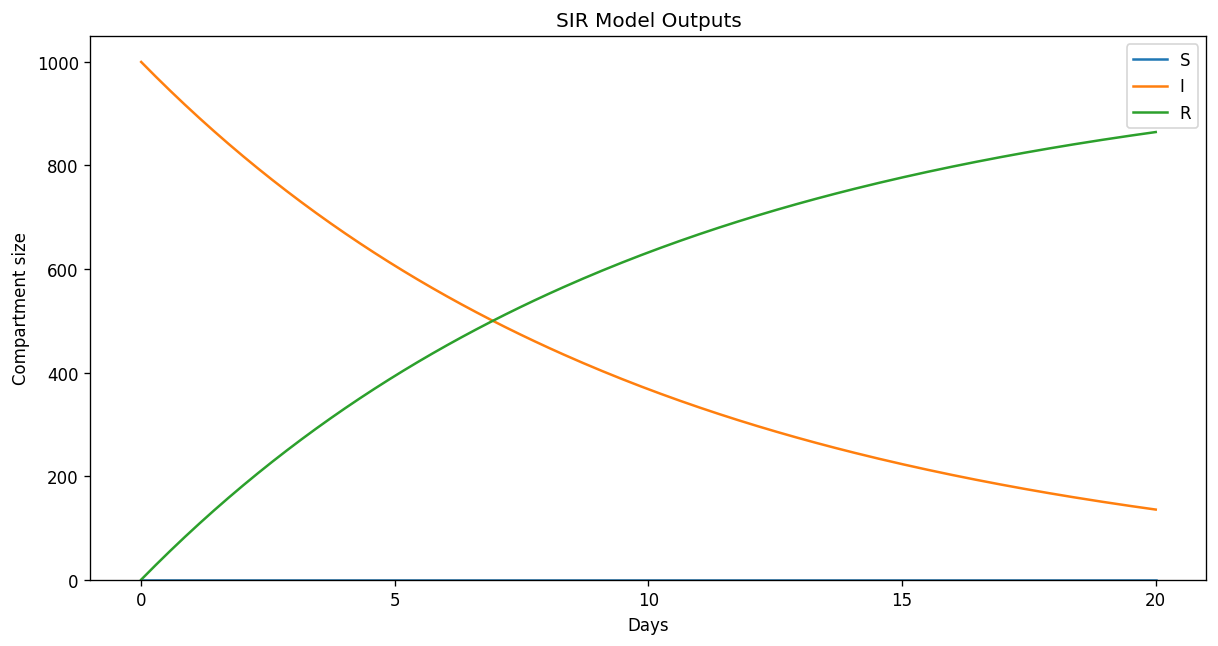

In [2]:
model = build_model()
model.set_initial_population(distribution={"I": 1000})

# Add a recovery flow where 10% of the source recover per time unit.
model.add_standard_transition_flow("recovery", fractional_rate=0.1, source="I", dest="R")

model.run()
plot_compartments(model)

## Time varying parameters (fractional flow)

The rate at which people transition can be set as a constant, or it can be defined as a function of time. This is the case of **all of the flows**: every parameter can be a constant _or_ a function of time.

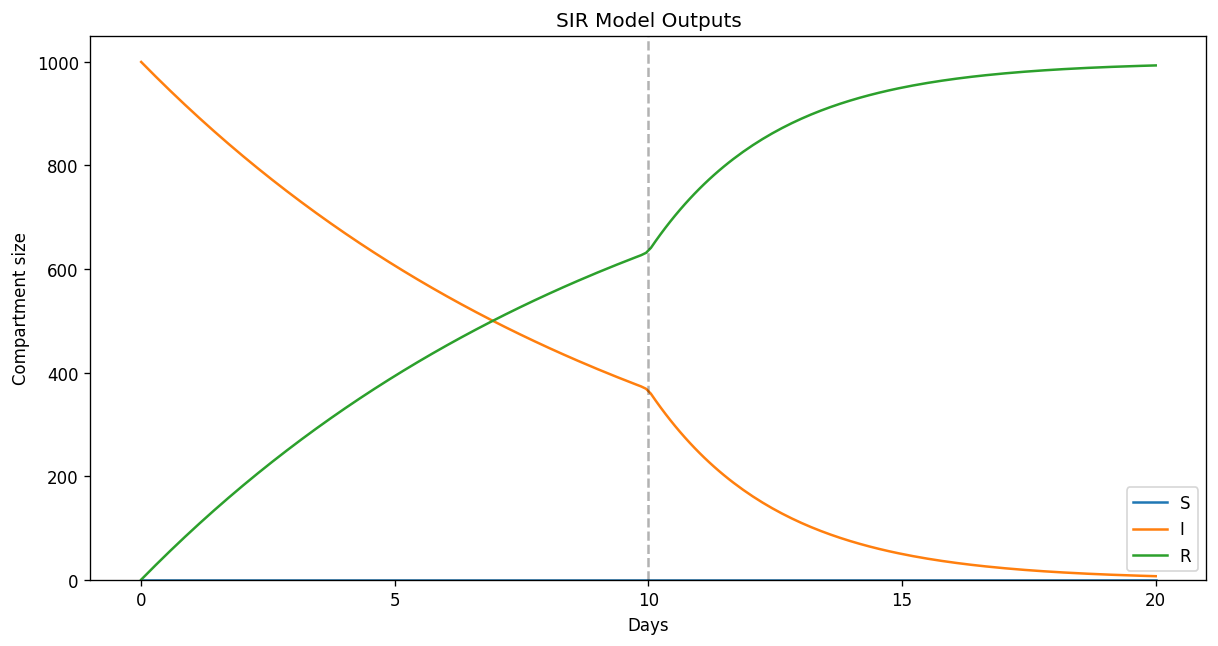

In [3]:
model = build_model()
model.set_initial_population(distribution={"S": 0, "I": 1000})

def recovery_rate(time):
    """
    Returns the recovery rate for a given time.
    People recover faster after day ten due to a magic drug.
    """
    if time < 10:
        return 0.1
    else:
        return 0.4
    
    
# Add a recovery flow where 10% of the source recover per time unit.
model.add_standard_transition_flow("recovery", recovery_rate, "I", "R")

# Use Runge-Kutta 4 solver to better capture sharp discontinuity.
model.run(solver="rk4")
plot_compartments(model, times=[10])

## Sojourn flow

A sojourn flow is essentially the same as a fractional flow, except instead of specifying a percentage of people who transition per time-unit, you instead specify the mean number of time units that someone stays (or sojourns) in the source compartment. This is mostly a convenience thing.

So `sojourn_time = 1 / fractional_rate`

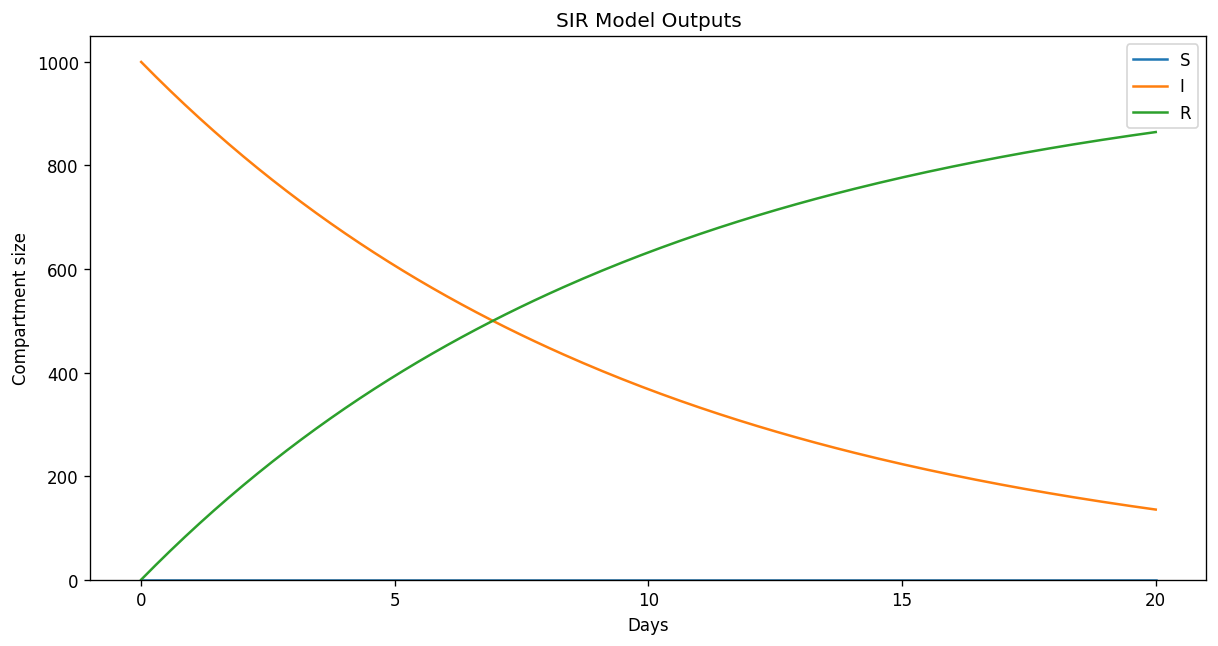

In [4]:
model = build_model()
model.set_initial_population(distribution={"I": 1000})

# Add a recovery flow where a person takes an average of 10 time units (i.e. days) to recover.
# This effectively means that 10% of people recover per time unit.
model.add_sojourn_flow("recovery", sojourn_time=10, source="I", dest="R")

model.run()
plot_compartments(model)

## Infection density flow

This flow can be used to model infections using density-dependent disease transmission (as opposed to frequency dependent). This [article](https://parasiteecology.wordpress.com/2013/10/17/density-dependent-vs-frequency-dependent-disease-transmission/) may be helpful in understanding the difference between the two methods.

In unstratified models, the density-dependent infection flow rate (people infected per time unit) is calculated as:

```python
# contact_rate: Rate at which effective contact happens between two individuals, i.e. contact that would result in transmission were it to occur between a susceptible and an infectious person
# num_source: Number of people in the (susceptible) source compartment
# num_infectious: Number of people infectious
force_of_infection = contact_rate * num_infectious
flow_rate = force_of_infection * num_source
```

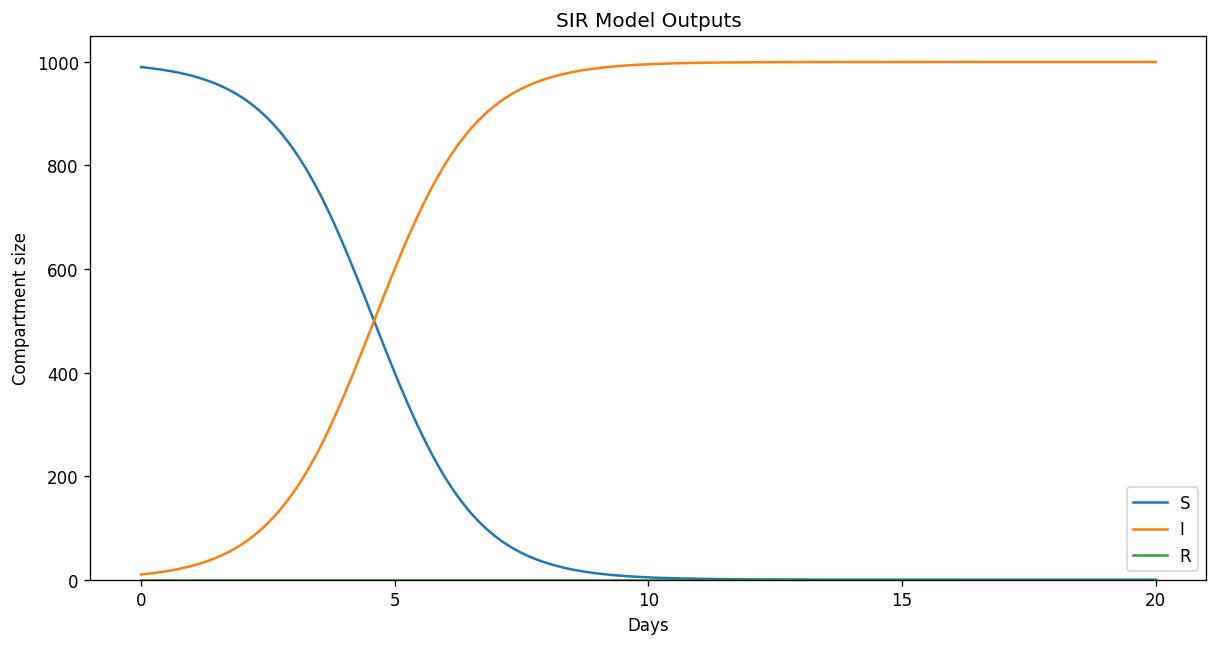

In [5]:
model = build_model()
model.set_initial_population(distribution={"S": 990, "I": 10})

# Add a density dependent infection flow. 
model.add_infection_density_flow("infection", contact_rate=1e-3, source="S", dest="I")

model.run()
plot_compartments(model)

## Infection frequency flow

This flow can be used to model infections using frequency-dependent disease transmission.

In unstratified models, the frequency-dependent infection flow rate (the number of people infected per time unit) is calculated as:


```python
# contact_rate: Rate at which contact happens between people and results in a transmission
# num_source: Number of people in the (susceptible) source compartment
# num_infectious: Number of people infected
# num_pop: Total number of people in the population
force_of_infection = contact_rate * num_infectious / num_pop
flow_rate = force_of_infection * num_source
```

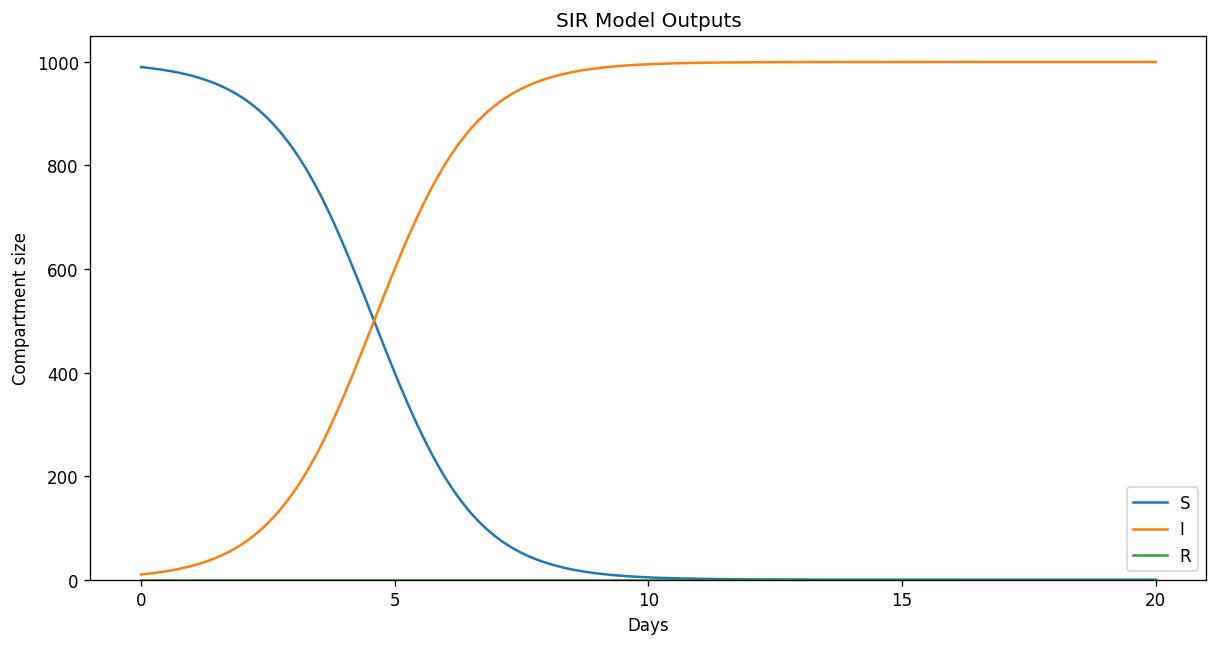

In [6]:
model = build_model()
model.set_initial_population(distribution={"S": 990, "I": 10})

# Add a frequency dependent infection flow. 
model.add_infection_frequency_flow("infection", contact_rate=1, source="S", dest="I")

model.run()
plot_compartments(model)

## Death flow

With a death flow, some percent of people in a user-selected source compartment die and leave the system every time unit.

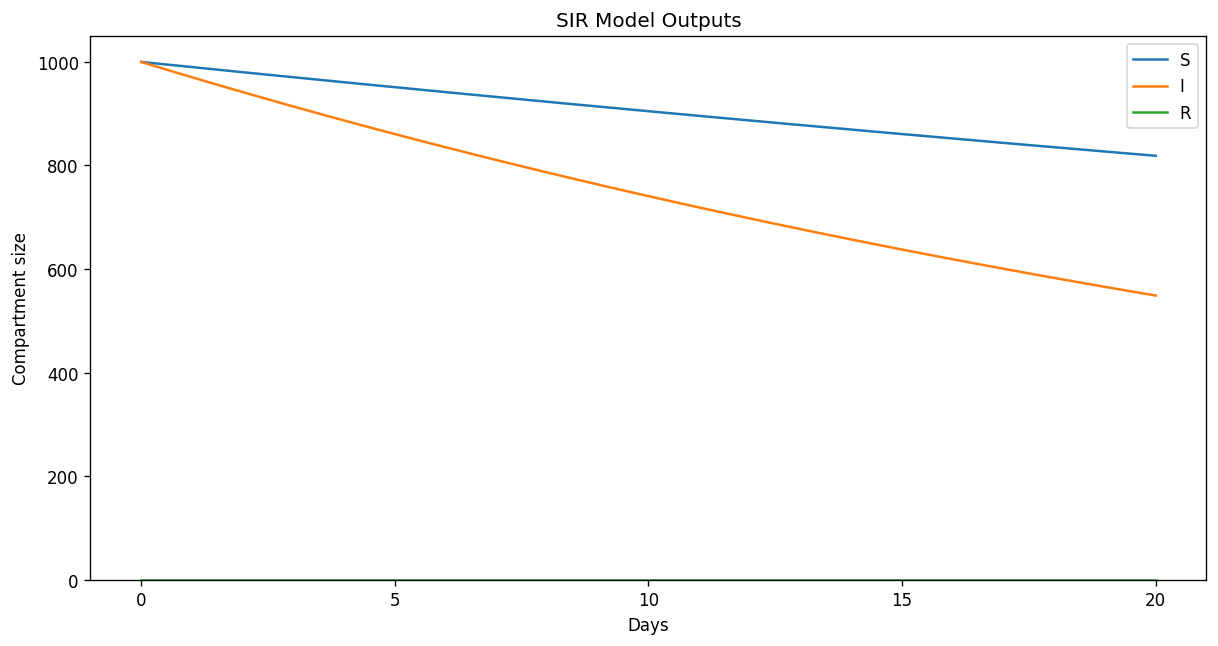

In [7]:
model = build_model()
model.set_initial_population(distribution={"S": 1000, "I": 1000})

# 3% of the infected population die per day due to the infection.
model.add_death_flow("infection_death", death_rate=0.03, source="I")

# 1% of the susceptible population die per day due to tiger attacks. 
model.add_death_flow("tiger_death", death_rate=0.01, source="S")

model.run()
plot_compartments(model)

## Universal death flow

Adding "universal deaths" is a convenient way to set up a death flow for every compartment, which can account for non-disease mortality (heart disease and getting hit by a bus). This is functionally the same as manually adding a death flow for every compartment. You can adjust the universal death rate for particlar strata later during the stratification process (e.g. age-based mortality).

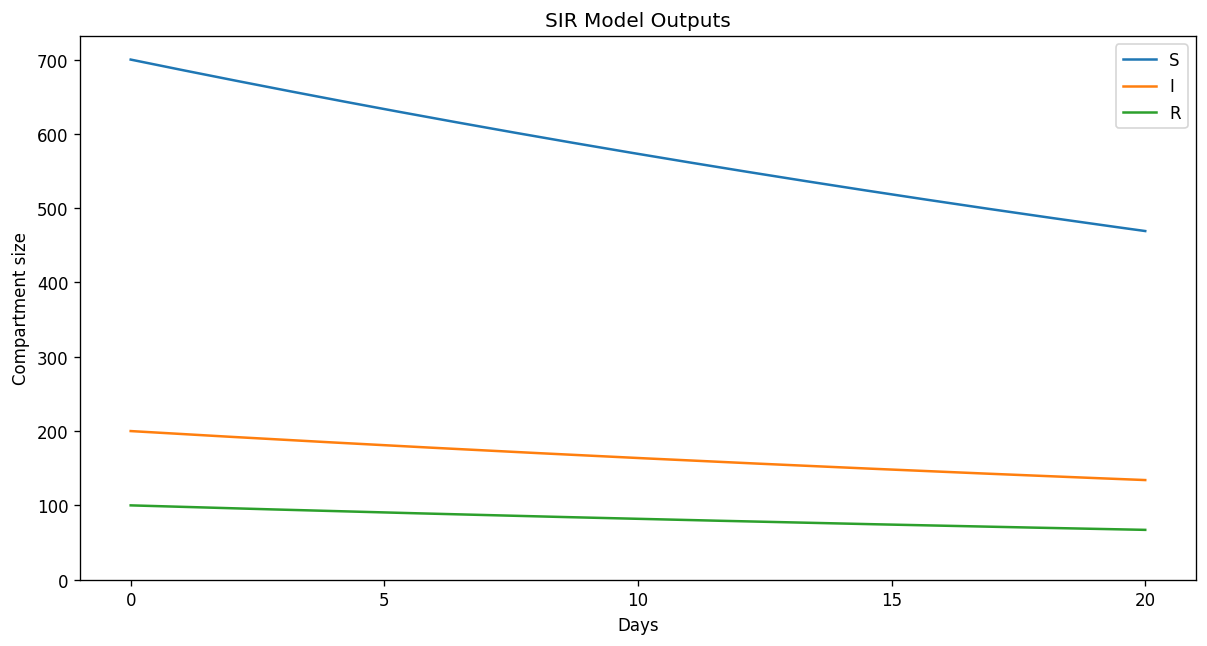

In [8]:
model = build_model()
model.set_initial_population(distribution={"S": 700, "I": 200, "R": 100})

# 2% of the population die per day for non-infection-related reasons.
model.add_universal_death_flows("universal_death", death_rate=0.02)

model.run()
plot_compartments(model)

## Crude birth flow

Some percentage of the total population are born into the destination compartment every time unit.

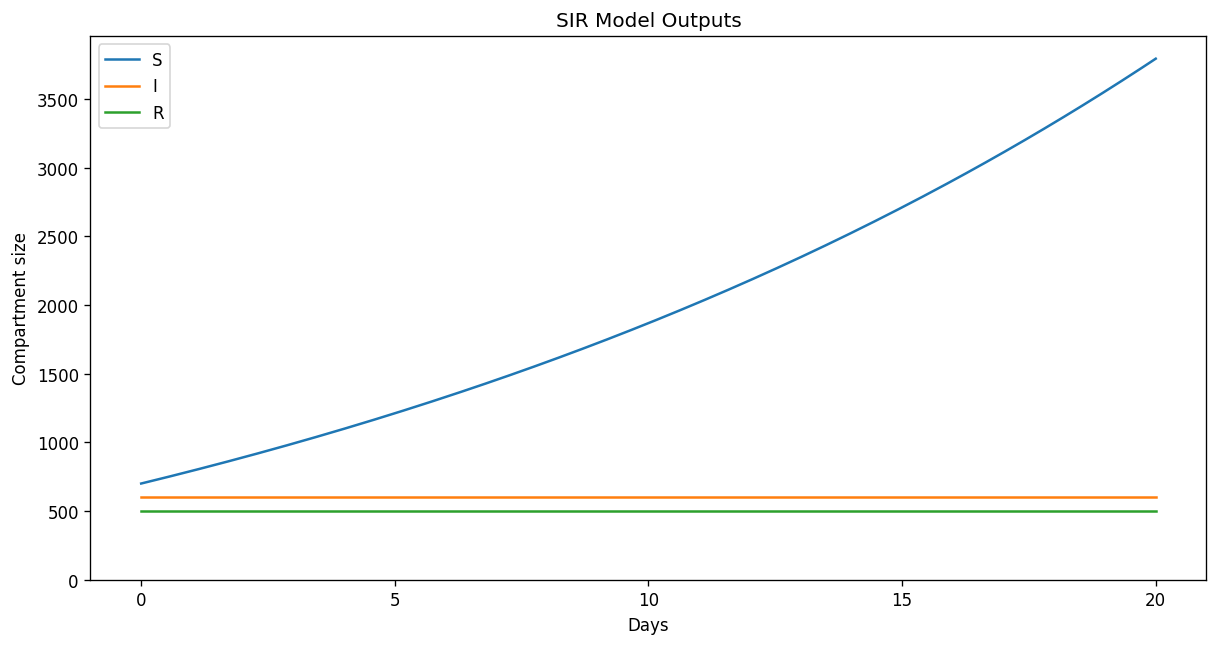

In [9]:
model = build_model()
model.set_initial_population(distribution={"S": 700, "I": 600, "R": 500})

# 5% of the total population per day are born as susceptible.
model.add_crude_birth_flow("birth", birth_rate=0.05, dest="S")

model.run()
plot_compartments(model)

## Importation flow

An absolute number of people arrive in the destination per time unit. This can be used to model arrivals from outside of the modelled region.

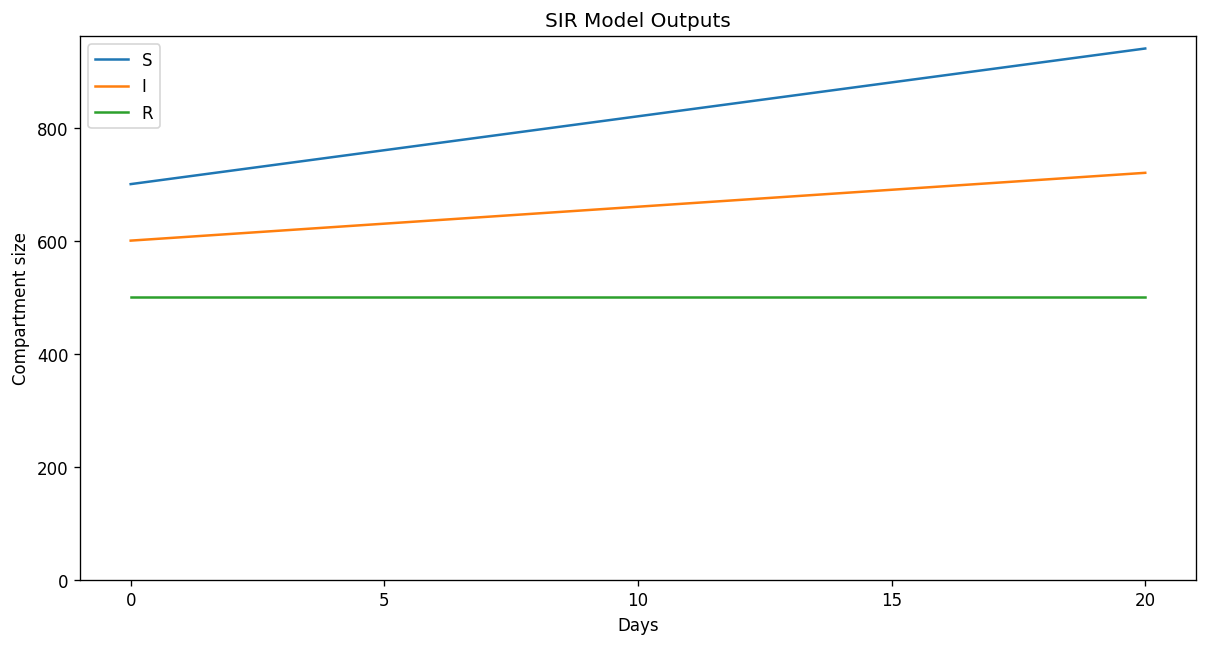

In [10]:
model = build_model()
model.set_initial_population(distribution={"S": 700, "I": 600, "R": 500})

# 12 susceptible people arrive per year.
model.add_importation_flow("imports", num_imported=12, dest="S")

# 6 infected people arrive per year.
model.add_importation_flow("imports", num_imported=6, dest="I")

model.run()
plot_compartments(model)

## Replacement birth flow

Add a flow to replace the number of deaths into the destination compartment. This means the total population should be conserved over time.

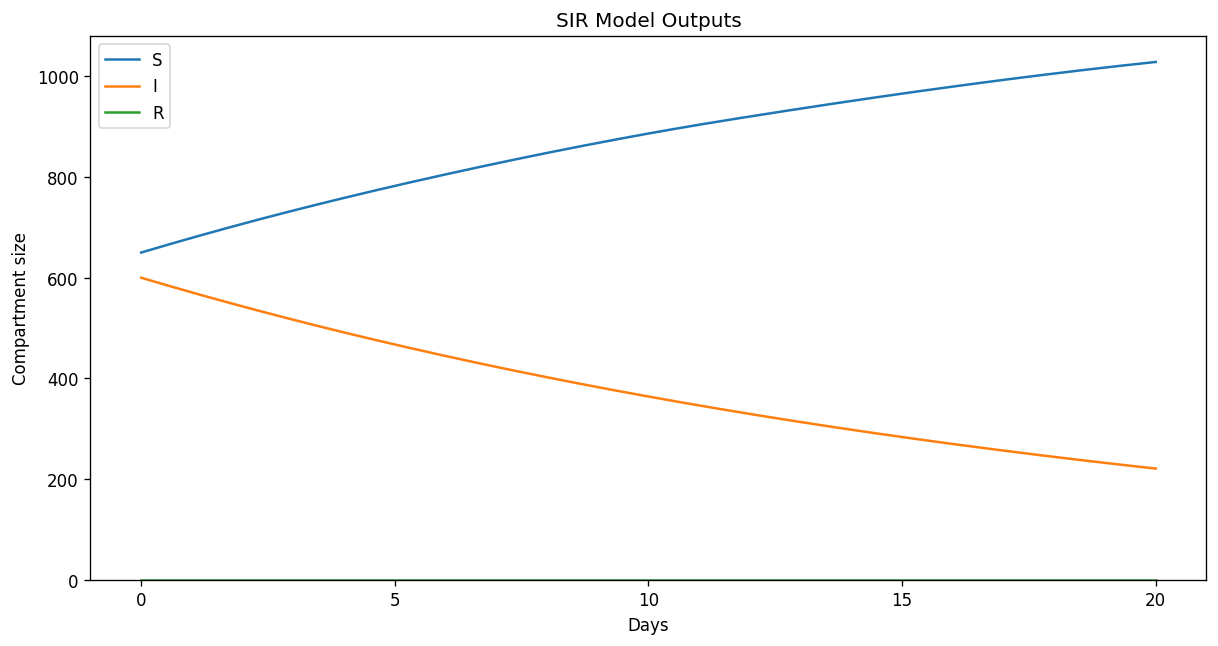

In [11]:
model = build_model()
model.set_initial_population(distribution={"S": 650, "I": 600, "R": 0})

# 5% of the infected population die per year due to infection.
model.add_death_flow("infection_death", death_rate=0.05, source="I")

# The infected people who have died arrive back in the susceptible compartment.
model.add_replacement_birth_flow("births", dest="S")

model.run()
plot_compartments(model)

## Function flow

A function flow gives you more control over how a flow should work. This is when you need to include more complex behaviour in your model which cannot be expressed using the built-in flows above.

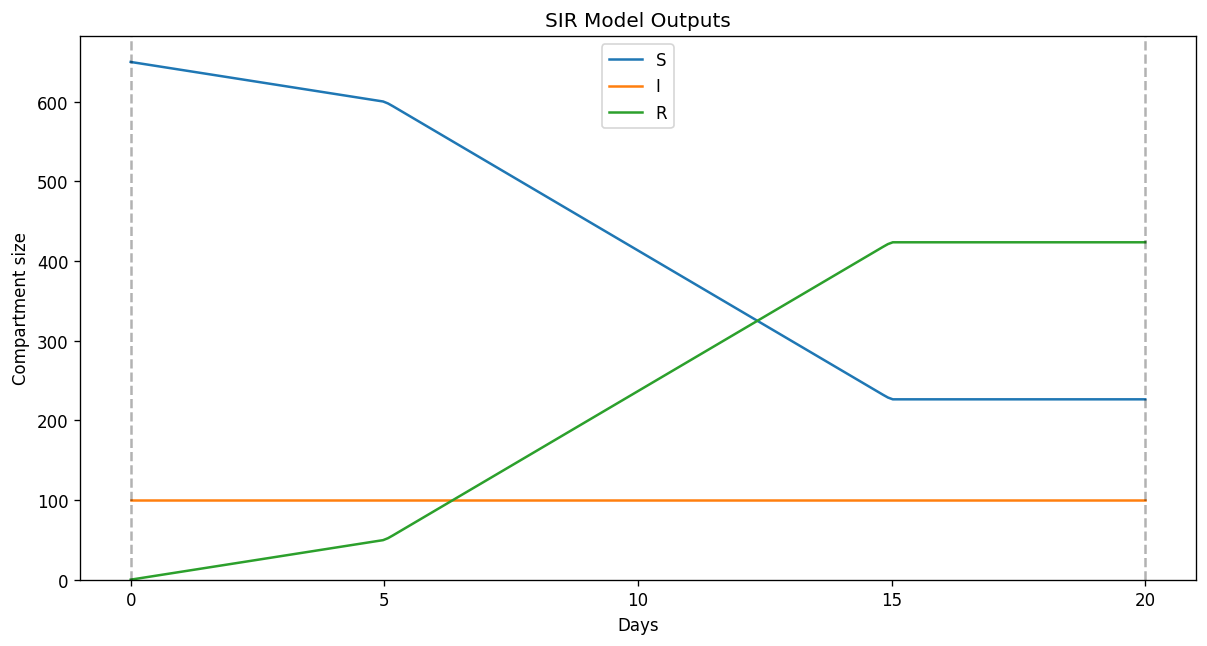

In [12]:
model = build_model()
model.set_initial_population(distribution={"S": 650, "I": 100, "R": 0})

def get_vaccination_flow_rate(flow, comp_names, comp_vals, flows, flow_rates, time):
    """
    Returns the flow-rate of susceptible people who get vaccinated and become recovered.
    
    Args:
        flow: The flow object being run
        comp_names: List of compartment names (Compartment)
        comp_vals: Array of compartment values at this timestep
        flows: List of flow objects (used to calculate flow rates)
        flow_rates: Calculated flow rate for each non-function flow at this timestep
        time: Current timestep
    
    Returns: The flow rate (float)
    """
    if time < 5:
        # Vaccinate 10 people per day until day 5
        return 10
    elif 5 < time < 15:
        # Vaccinate 5% of the total population per day until day 15
        return 0.05 * comp_vals.sum()
    else:
        # After day 15 stop vaccinations, because we ran out of money
        return 0
    

# Use a custom function to model vaccinations
model.add_function_flow("vacinnation", flow_rate_func=get_vaccination_flow_rate, source="S", dest="R")

# Use Runge-Kutta 4 solver to better capture sharp discontinuity.
model.run(solver="rk4")
plot_compartments(model, times=[0, 20])

## Summary

That's it for now, now you know how to use all the flow types available in summer to define the dynamics of your compartmental model. In future examples you will see how to use these flows in a stratified model.

A detailed API reference of the CompartmentalModel class can be found [here](http://summerepi.com/api/model.html)